> # **1. Install packages**

In [1]:
%%capture
!pip install torchmetrics
!pip install torchinfo

# **2. Import libraries**

In [2]:
# Data handling
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# Preprocessing
import cv2
from sklearn.model_selection import train_test_split as tts

# Torch
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torchmetrics.classification import MulticlassAccuracy
from torchvision.models import resnet50, ResNet50_Weights

# Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

# os
import os

# Path
from pathlib import Path

# tqdm
from tqdm.auto import tqdm

# typing
from typing import Dict, List

# Counter
from collections import Counter

# random
import random

# Warnings
import warnings
warnings.filterwarnings('ignore')

# **3. Load data and EDA**

In [3]:
# Let's see how many images we have.
IMAGE_PATH = Path("SB-FishDisease")

image_path_list_jpg = list(IMAGE_PATH.glob("*/*.jpg"))
image_path_list_jpeg = list(IMAGE_PATH.glob("*/*.jpeg"))
image_path_list_png = list(IMAGE_PATH.glob("*/*.png"))
image_path_list_JPG = list(IMAGE_PATH.glob("*/*.JPG"))
image_path_list_webp = list(IMAGE_PATH.glob("*/*.webp"))

TOTAL_IMAGE_PATH_LIST = image_path_list_jpg + image_path_list_jpeg + image_path_list_png\
                        + image_path_list_JPG + image_path_list_webp

print(f'Total Images = {len(TOTAL_IMAGE_PATH_LIST)}')

Total Images = 617


In [4]:
# Let's visualize how many classes we have.
classes = sorted(os.listdir(IMAGE_PATH))
classes

['Bacterial Red disease',
 'Bacterial diseases - Aeromoniasis',
 'Bacterial gill disease',
 'Fungal diseases Saprolegniasis',
 'Healthy Fish',
 'Parasitic diseases',
 'Viral diseases White tail disease']

In [5]:
# Let's see how many images per class we have.
class_count = []
for i in TOTAL_IMAGE_PATH_LIST:
    class_count.append(i.parent.stem)

Counter(class_count)

Counter({'Healthy Fish': 246,
         'Bacterial diseases - Aeromoniasis': 77,
         'Bacterial Red disease': 68,
         'Fungal diseases Saprolegniasis': 65,
         'Bacterial gill disease': 58,
         'Viral diseases White tail disease': 55,
         'Parasitic diseases': 48})

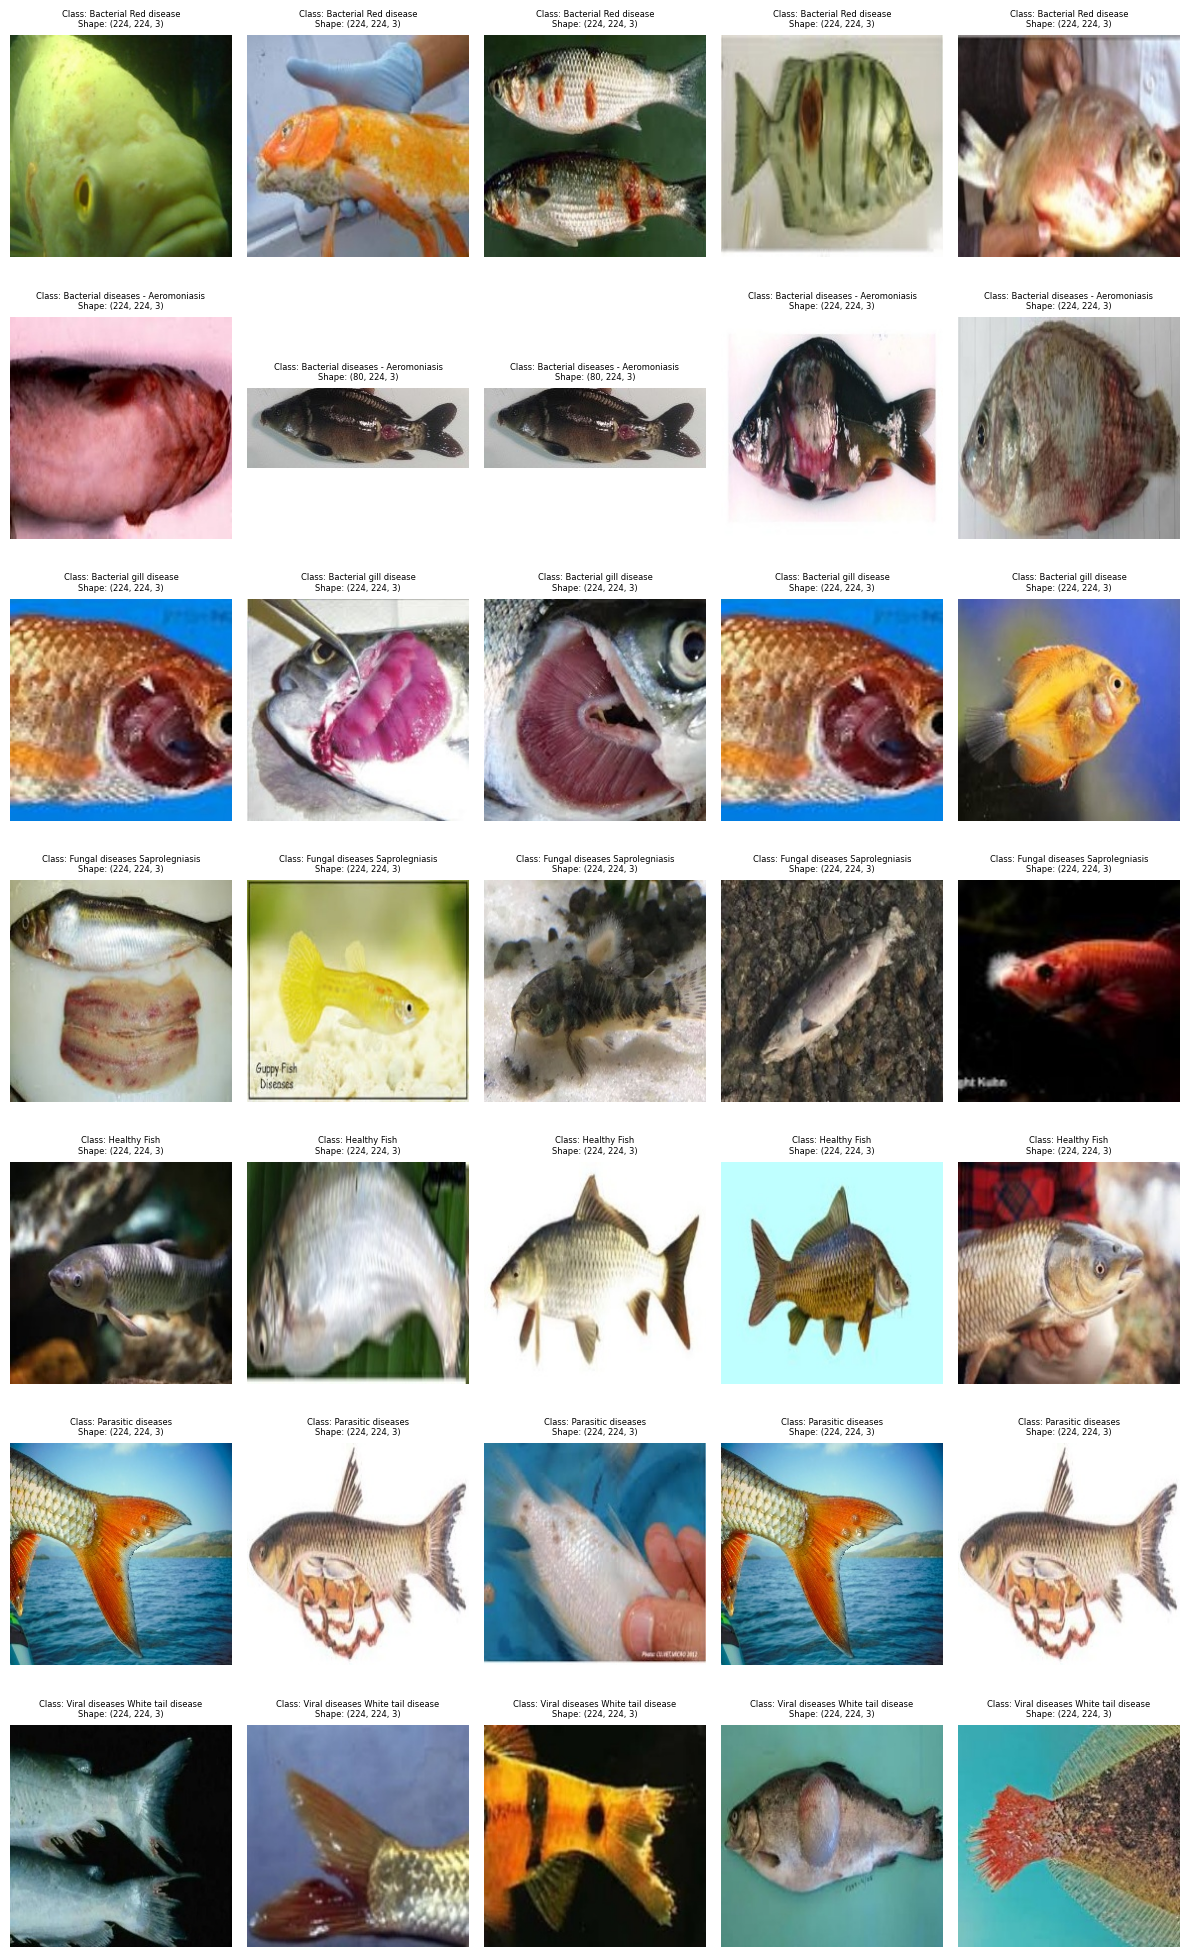

In [6]:
# Let's visualize 5 images for each class.

fig,ax = plt.subplots(nrows = 7, ncols = 5, figsize = (12,20))
p = 0
for c in classes:
    
    a = random.choices(list(Path(os.path.join(IMAGE_PATH, c)).glob("*.jpg")), k = 5)
    
    for i,j in enumerate(a):
        img_BGR = cv2.imread(str(j))
        img_RGB = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB)
        ax[p,i].imshow(img_RGB)
        ax[p,i].set_title(f'Class: {j.parent.stem}\nShape: {img_RGB.shape}', fontsize = 6)
        ax[p,i].axis('off')
    p += 1
        
fig.tight_layout()
fig.show()

**We see that the images have different sizes, so we will proceed to see how the width and height of the images are distributed.**

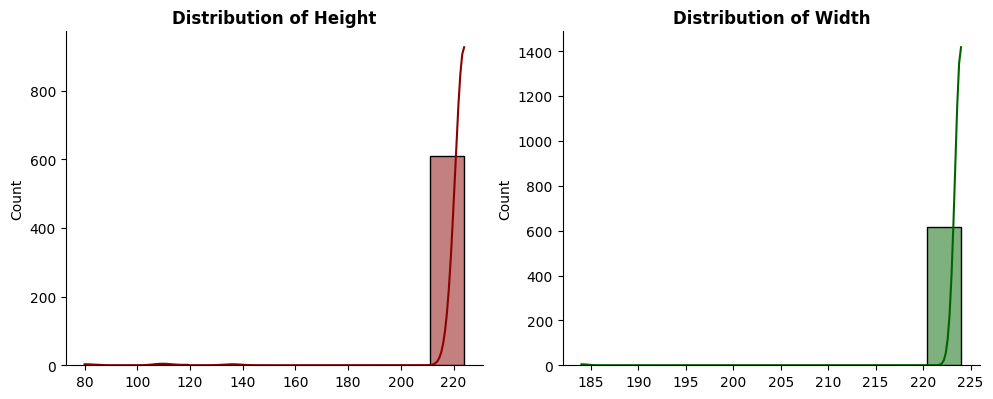

In [7]:
seq_height = []
seq_width = []

for i in TOTAL_IMAGE_PATH_LIST:
    img_BGR = cv2.imread(str(i))
    img_RGB = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB)
    seq_height.append(img_RGB.shape[0])
    seq_width.append(img_RGB.shape[1])
    
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10,4.1))
ax = ax.flat

sns.histplot(seq_height, kde = True, color = 'darkred', ax = ax[0])
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].set_title('Distribution of Height', fontweight = 'bold', color = 'black')

sns.histplot(seq_width, kde = True, color = 'darkgreen', ax = ax[1])
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].set_title('Distribution of Width', fontweight = 'bold', color = 'black')

fig.tight_layout()
fig.show()

In [8]:
df_height_width = pd.DataFrame({'height':seq_height, 'width':seq_width})

df_height_width.describe().T

,count,mean,std,min,25%,50%,75%,max
height,617.0,222.692058,12.426504,80.0,224.0,224.0,224.0,224.0
width,617.0,223.870340,2.275515,184.0,224.0,224.0,224.0,224.0


# **4. Preprocessing**

In [9]:
# Let's create our pd.DataFrame to store the path of the images and their respective label.
img_path_and_label = {'img_path':[], 
                      'label':[]}

for img_pth in TOTAL_IMAGE_PATH_LIST:
    img_path_and_label['img_path'].append(img_pth)
    img_path_and_label['label'].append(img_pth.parent.stem)
    
df_path_and_label = pd.DataFrame(img_path_and_label)
df_path_and_label.head()

,img_path,label
0,SB-FishDisease\Bacterial diseases - Aeromonias...,Bacterial diseases - Aeromoniasis
1,SB-FishDisease\Bacterial diseases - Aeromonias...,Bacterial diseases - Aeromoniasis
2,SB-FishDisease\Bacterial diseases - Aeromonias...,Bacterial diseases - Aeromoniasis
3,SB-FishDisease\Bacterial diseases - Aeromonias...,Bacterial diseases - Aeromoniasis
4,SB-FishDisease\Bacterial diseases - Aeromonias...,Bacterial diseases - Aeromoniasis


In [10]:
# Now we are going to separate the paths of the images and their respective label.
X = df_path_and_label.drop('label', axis = 1)
y = df_path_and_label['label']

# Then, let's split into training and test set.
# But first we define the random seed for reproducibility.
SEED = 42

X_train, X_test, y_train, y_test = tts(X,y, test_size = 0.2, random_state = SEED, stratify = y)

In [11]:
print('Total Images of training set:')
print(Counter(y_train))
print('')

print('Total Images of test set:')
print(Counter(y_test))

Total Images of training set:
Counter({'Healthy Fish': 197, 'Bacterial diseases - Aeromoniasis': 62, 'Bacterial Red disease': 54, 'Fungal diseases Saprolegniasis': 52, 'Bacterial gill disease': 46, 'Viral diseases White tail disease': 44, 'Parasitic diseases': 38})

Total Images of test set:
Counter({'Healthy Fish': 49, 'Bacterial diseases - Aeromoniasis': 15, 'Bacterial Red disease': 14, 'Fungal diseases Saprolegniasis': 13, 'Bacterial gill disease': 12, 'Viral diseases White tail disease': 11, 'Parasitic diseases': 10})


In [12]:
classes

['Bacterial Red disease',
 'Bacterial diseases - Aeromoniasis',
 'Bacterial gill disease',
 'Fungal diseases Saprolegniasis',
 'Healthy Fish',
 'Parasitic diseases',
 'Viral diseases White tail disease']

In [13]:
# Now we have to convert our labels to number, where:
# Bacterial Red disease = 0
# Bacterial diseases - Aeromoniasis = 1
# Bacterial gill disease = 2
# Fungal diseases Saprolegniasis = 3
# Healthy Fish = 4
# Parasitic diseases = 5
# Viral diseases White tail disease = 6

label_map = dict(zip(classes, range(0,7)))

y_train_array = np.array(y_train.map(label_map))
y_train_torch = torch.from_numpy(y_train_array)

y_test_array = np.array(y_test.map(label_map))
y_test_torch = torch.from_numpy(y_test_array)
y_test_torch

tensor([4, 4, 4, 6, 4, 0, 4, 3, 4, 1, 4, 4, 0, 4, 0, 3, 1, 2, 4, 5, 4, 4, 0, 3,
        4, 4, 2, 4, 6, 2, 4, 4, 4, 1, 4, 1, 4, 2, 3, 5, 4, 4, 1, 3, 6, 1, 3, 2,
        6, 1, 0, 0, 5, 4, 4, 1, 4, 2, 4, 6, 4, 4, 3, 0, 4, 3, 5, 4, 1, 4, 4, 4,
        4, 4, 4, 3, 6, 1, 5, 0, 5, 5, 2, 2, 4, 1, 3, 0, 2, 5, 2, 0, 4, 4, 6, 4,
        4, 4, 4, 4, 0, 5, 0, 3, 4, 3, 1, 4, 0, 2, 5, 4, 0, 1, 4, 6, 3, 1, 6, 2,
        6, 6, 4, 1])

In [14]:
# We define the transformations for our data set.
weights = ResNet50_Weights.DEFAULT
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [15]:
# We apply the transformations to our data sets.

images_train = [None] * len(X_train)

for i, (_,img_path_train) in enumerate(X_train.iterrows()):
    img_train = Image.open(img_path_train[0]).convert('RGB')
    images_train[i] = auto_transforms(img_train)
    
images_test = [None] * len(X_test)

for i, (_, img_path_test) in enumerate(X_test.iterrows()):
    img_test = Image.open(img_path_test[0]).convert('RGB')
    images_test[i] = auto_transforms(img_test)

In [16]:
# We will then convert our lists of tensors into a single tensor.
X_train_torch = torch.stack(images_train)
X_test_torch = torch.stack(images_test)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

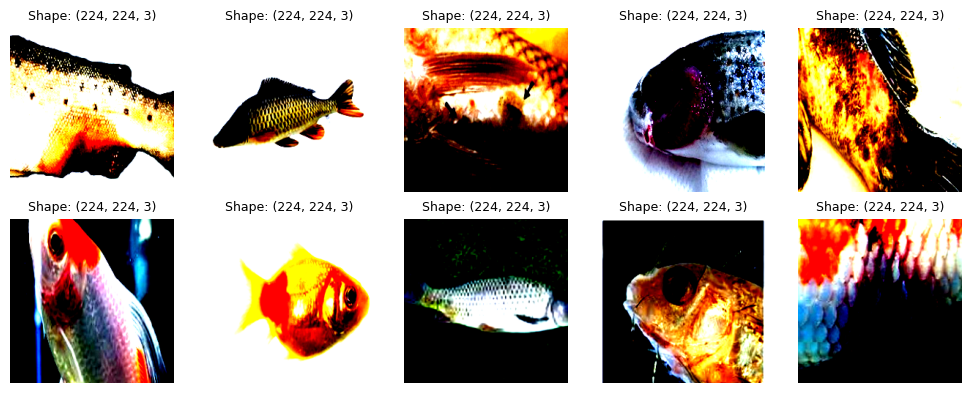

In [17]:
# Let's visualize some randomly selected transformed images.
indices = torch.randperm(10).numpy()

fig, ax = plt.subplots(nrows = 2, ncols = 5, figsize = (10,4))
ax = ax.flat

for i,j in enumerate(indices):
    IMG = X_train_torch[j].permute(1,2,0).numpy()
    ax[i].imshow(IMG)
    ax[i].set_title(f'Shape: {IMG.shape}', fontsize = 9)
    ax[i].axis('off')
    
fig.tight_layout()
fig.show()

**Now we have to convert our tensors into Datase's and then convert it into DataLoader's.**

In [18]:
# First of all, we convert to Dataset but for this we have to create a Dataset class.
class CustomDataset(Dataset):
    def __init__(self, data, target):
        self.data = data
        self.target = target
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.target[idx]
        
        return x,y

In [19]:
# Now we convert to Dataset.
train_dataset = CustomDataset(X_train_torch, y_train_torch)
test_dataset = CustomDataset(X_test_torch, y_test_torch)

In [40]:
# Then we convert to DataLoader.
BATCH_SIZE = 4
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(dataset = train_dataset, 
                              batch_size = BATCH_SIZE, 
                              shuffle = True, 
                              num_workers = NUM_WORKERS)

test_dataloader = DataLoader(dataset = test_dataset, 
                             batch_size = BATCH_SIZE, 
                             shuffle = False, 
                             num_workers = NUM_WORKERS)

In [41]:
# Let's visualize a batch.
images_batch, labels_batch = next(iter(train_dataloader))

images_batch.shape, labels_batch.shape

RuntimeError: DataLoader worker (pid(s) 28452, 19048) exited unexpectedly

# **5. Model**

In [33]:
# GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [34]:
# We define the model to use.
model = resnet50(weights = weights)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\skill/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:11<00:00, 9.26MB/s]


In [ ]:
# Now we visualize the architecture of the model.
summary(model = model, 
        input_size = [4,3,224,224], 
        col_names = ['input_size','output_size','num_params','trainable'], 
        col_width = 17, 
        row_settings = ['var_names'])

In [ ]:
# Now we freeze the parameters of the extractor layers.
for param in model.parameters():
    param.requires_grad = False

In [ ]:
# We go back to visualize how it looked after freezing the parameters.
# Now we visualize the architecture of the model.
summary(model = model, 
        input_size = [4,3,224,224], 
        col_names = ['input_size','output_size','num_params','trainable'], 
        col_width = 17, 
        row_settings = ['var_names'])


In [ ]:
# Let's visualize the last layer, which we will modify for our binary classification purpose.
model.fc

In [ ]:
# We modify the last layer.
output_shape = len(classes)

model.fc = nn.Linear(in_features = 2048, out_features = output_shape, bias = True)

In [ ]:
# We visualize our model again.
summary(model = model, 
        input_size = [4,3,224,224], 
        col_names = ['input_size','output_size','num_params','trainable'], 
        col_width = 17, 
        row_settings = ['var_names'])

In [ ]:
# Now let's visualize one step forward.

pred_logit = model(images_batch.to(device))
pred_logit

In [ ]:
# Let's define our loss function and the optimizer.
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr = 0.01, weight_decay = 0.1)

**We are going to define 3 functions to execute the training**:

- train_step
- checkpoint
- test_step
- train

In [ ]:

def train_step(model:torch.nn.Module, 
               dataloader:torch.utils.data.DataLoader, 
               loss_fn:torch.nn.Module, 
               optimizer:torch.optim.Optimizer):
    
    
    model.train()
    
    train_loss = 0.
    accuracy_train = MulticlassAccuracy(num_classes = len(classes), average = 'macro').to(device)
    
    for batch,(X,y) in enumerate(dataloader):
        X,y = X.to(device), y.to(device)
        y_pred_logit = model(X)
        
        loss = loss_fn(y_pred_logit, y)
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        y_pred_prob = torch.softmax(y_pred_logit, dim = 1)
        accuracy_train.update(y_pred_prob, y)
        
    train_loss = train_loss/len(dataloader)
    train_accuracy = accuracy_train.compute()
    accuracy_train.reset()
    
    return train_loss, train_accuracy

In [ ]:
def save_checkpoint(filename, model, loss, epoch, optimizer):
    state = {'filename':filename, 
             'model':model.state_dict(), 
             'loss':loss, 
             'epoch':epoch, 
             'optimizer':optimizer.state_dict()}
    
    torch.save(state, filename)

In [ ]:
def test_step(model:torch.nn.Module, 
              dataloader:torch.utils.data.DataLoader, 
              loss_fn:torch.nn.Module):
    
    
    model.eval()
    
    test_loss = 0.
    accuracy_test = MulticlassAccuracy(num_classes = len(classes), average = 'macro').to(device)
    
    with torch.inference_mode():
        for batch,(X,y) in enumerate(dataloader):
            X,y = X.to(device), y.to(device)
            y_pred_logit = model(X)
            
            loss = loss_fn(y_pred_logit, y)
            test_loss += loss.item()
            
            y_pred_prob = torch.softmax(y_pred_logit, dim = 1)
            accuracy_test.update(y_pred_prob, y)
            
    test_loss = test_loss/len(dataloader)
    test_accuracy = accuracy_test.compute()
    accuracy_test.reset()
    
    return test_loss, test_accuracy

In [ ]:
def train(model:torch.nn.Module, 
          train_dataloader:torch.utils.data.DataLoader, 
          test_dataloader:torch.utils.data.DataLoader, 
          loss_fn:torch.nn.Module, 
          optimizer:torch.optim.Optimizer, 
          epochs:int):
    
    results = {'train_loss':[], 
               'train_accuracy':[], 
               'test_loss':[], 
               'test_accuracy':[]}
    
    best_test_loss = float('inf')
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_accuracy = train_step(model = model, 
                                        dataloader = train_dataloader, 
                                        loss_fn = loss_fn, 
                                        optimizer = optimizer)
        
        
        test_loss, test_accuracy = test_step(model = model, 
                                     dataloader = test_dataloader, 
                                     loss_fn = loss_fn)
        
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            
            file_name = 'best_model.pt'
            
            save_checkpoint(file_name, model, best_test_loss, epoch, optimizer)
            
        print(f'Epoch: {epoch + 1} | ', 
              f'Train Loss: {train_loss:.4f} | ', 
              f'Train Accuracy: {train_accuracy:.4f} | ', 
              f'Test Loss: {test_loss:.4f} | ', 
              f'Test Accuracy: {test_accuracy:.4f}')
        
        results['train_loss'].append(train_loss)
        results['train_accuracy'].append(train_accuracy)
        results['test_loss'].append(test_loss)
        results['test_accuracy'].append(test_accuracy)
        
    return results

In [ ]:
# Training !!

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

EPOCHS = 100

MODEL_RESULTS = train(model.to(device), 
                      train_dataloader, 
                      test_dataloader, 
                      loss_fn, 
                      optimizer, 
                      EPOCHS)

In [ ]:
# Function to plot the loss and metric during each training epoch.
def plot_loss_metric_curve(model_results:Dict[str,List[float]]):
    
    train_loss = model_results["train_loss"]
    test_loss = model_results["test_loss"]
    
    train_accuracy = [float(value) for value in model_results["train_accuracy"]]
    test_accuracy = [float(value) for value in model_results["test_accuracy"]]
    
    fig,axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10,4))
    plt.style.use("ggplot")
    axes = axes.flat
    
    axes[0].plot(train_loss, color = "red", label = "Train")
    axes[0].plot(test_loss, color = "blue", label = "Test")
    axes[0].set_title("CrossEntropyLoss", fontsize = 12, fontweight = "bold", color = "black")
    axes[0].set_xlabel("Epochs", fontsize = 10, fontweight = "bold", color = "black")
    axes[0].set_ylabel("Loss", fontsize = 10, fontweight = "bold", color = "black")
    axes[0].legend()
    
    axes[1].plot(train_accuracy, color = "red", label = "Train")
    axes[1].plot(test_accuracy, color = "blue", label = "Test")
    axes[1].set_title("Metric of performance: Accuracy", fontsize = 12, fontweight = "bold", color = "black")
    axes[1].set_xlabel("Epochs", fontsize = 10, fontweight = "bold", color = "black")
    axes[1].set_ylabel("Score", fontsize = 10, fontweight = "bold", color = "black")
    axes[1].legend()
    
    fig.tight_layout()
    fig.show()

In [ ]:
plot_loss_metric_curve(MODEL_RESULTS)

In [ ]:
# We load the best model.
path_checkpoint = "/kaggle/working/best_model.pt"
checkpoint = torch.load(path_checkpoint)

In [ ]:
# The best model gave us:

print(f'Best test loss = {checkpoint["loss"]}')
print(f'Epoch = {checkpoint["epoch"]+1}')

**Predictions**

In [ ]:
model.to(device)
model.load_state_dict(checkpoint["model"])

model.eval()
with torch.inference_mode():
    y_pred_logits_train = model(X_train_torch.to(device))
    y_pred_logits_test = model(X_test_torch.to(device))

In [ ]:
y_pred_prob_train = torch.softmax(y_pred_logits_train, dim = 1).cpu()
y_pred_class_train = torch.argmax(y_pred_prob_train, dim = 1).numpy().astype(int)

y_pred_prob_test = torch.softmax(y_pred_logits_test, dim = 1).cpu()
y_pred_class_test = torch.argmax(y_pred_prob_test, dim = 1).numpy().astype(int)

# **6. Metrics**

**Confusion Matrix**

In [ ]:
cf_mx_train = confusion_matrix(y_train_array.astype(int), y_pred_class_train)
cf_mx_test = confusion_matrix(y_test_array.astype(int), y_pred_class_test)

In [ ]:
# Confusion Matrix Plot
fig,ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20,8))
ax = ax.flat
sns.heatmap(cf_mx_train, 
            cmap = 'Blues', 
            annot = True, 
            fmt = ' ', 
            annot_kws = {"fontsize":10, 
                         "fontweight":"bold"}, 
            linewidths = 1, 
            linecolor = "white", 
            cbar = False, 
            square = True, 
            xticklabels = classes,
            yticklabels = classes,
            ax = ax[0])
ax[0].set_title('Confusion Matrix Train', fontsize = 12, fontweight = 'bold', color = 'black')

sns.heatmap(cf_mx_test, 
            cmap = 'Reds', 
            annot = True, 
            fmt = ' ', 
            annot_kws = {"fontsize":10, 
                         "fontweight":"bold"}, 
            linewidths = 1, 
            linecolor = "white", 
            cbar = False, 
            square = True, 
            xticklabels = classes, 
            yticklabels = classes,
            ax = ax[1])
ax[1].set_title('Confusion Matrix Test', fontsize = 12, fontweight = 'bold', color = 'black')

fig.tight_layout()
fig.show()

**Accuray score**

In [ ]:
print(f'Accuracy train = {accuracy_score(y_train_array.astype(int), y_pred_class_train)}')

print(f'Accuracy test = {accuracy_score(y_test_array.astype(int), y_pred_class_test)}')

**Classification Report**

In [ ]:
# To perform a reverse mapping, go from id to label.
id2label = dict(zip(range(0,7),classes))
id2label

In [ ]:
print("=="*40)
print(" " * 25, "Classification Report Train")
print("=="*40)
print(classification_report(pd.Series(y_train_array).map(id2label), 
                            pd.Series(y_pred_class_train).map(id2label),))

print("=="*40)
print(" " * 25, "Classification Report Test")
print("=="*40)
print(classification_report(pd.Series(y_test_array).map(id2label), 
                            pd.Series(y_pred_class_test).map(id2label)))